In [1]:
import umap
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import spearmanr

plt.style.use("jupyter")

In [2]:
iza = pd.read_csv("../data/iza_nnpscan_dm.csv", index_col=0)
zfeat = pd.read_csv("../data/iza_nnpscan_features.csv", index_col=0)

hyp = pd.read_csv("../data/hyp_dm.csv", index_col=0)
hfeat = pd.read_csv("../data/hyp_features.csv", index_col=0)

In [3]:
full = pd.concat([iza, hyp], axis=0).reset_index(drop=True)
feats = pd.concat([zfeat, hfeat], axis=0).reset_index(drop=True)

## UMAP descriptors

In [4]:
def get_range(X):
    """Get range for plotting hexbins"""
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin
    maxrange = max(xrange, yrange)
    xadd = maxrange - xrange
    yadd = maxrange - yrange

    xmin, xmax = xmin - xadd / 2, xmax + xadd / 2
    ymin, ymax = ymin - yadd / 2, ymax + yadd / 2
    
    return xmin, xmax, ymin, ymax

In [5]:
um = umap.UMAP(n_neighbors=10, random_state=42, metric="precomputed")
um.fit(iza)
umxy = um.transform(full.values)

/Users/schwalbekoda1/envs/zeo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/schwalbekoda1/envs/zeo/lib/python3.9/site-packages/umap/umap_.py:2830: UserWarning: Transforming new data with precomputed metric. We are assuming the input data is a matrix of distances from the new points to the points in the training set. If the input matrix is sparse, it should contain distances from the new points to their nearest neighbours or approximate nearest neighbours in the training set.
  warn(


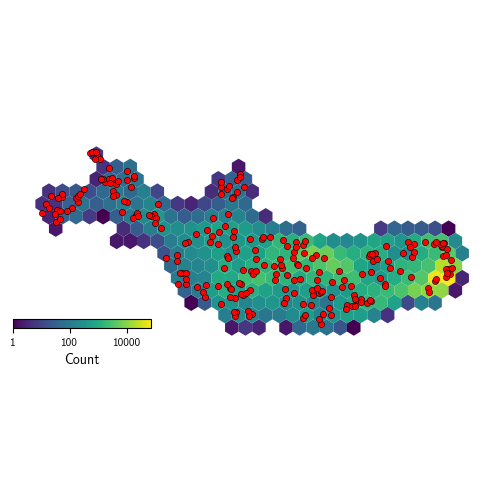

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

X = umxy

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
    bins="log"
)

subX = X[:len(iza)]
ax.scatter(
    subX[:, 0],
    subX[:, 1],
    c="r",
    s=20,
    edgecolors="k",
    linewidths=0.4,
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.7, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [1e0, 1e2, 1e4]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=8)
cbar.set_label("Count", fontsize=10)

# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

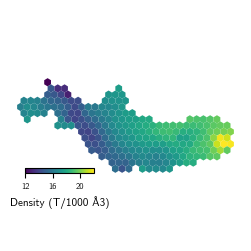

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

X = umxy

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["density"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.6, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [12, 16, 20]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=6)
cbar.set_label("Density (T/1000 Å3)", fontsize=8)

# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

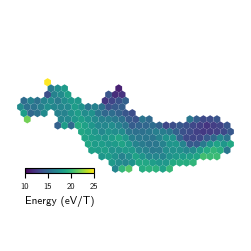

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))

X = umxy

norm = plt.Normalize(10, 25)

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["relative_energy"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
    norm=norm,
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.6, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [10, 15, 20, 25]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=6)
cbar.set_label("Energy (eV/T)", fontsize=8)


# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

## Analyzing only the structures close to IZA

In [9]:
close = full.min(1) < 0.1

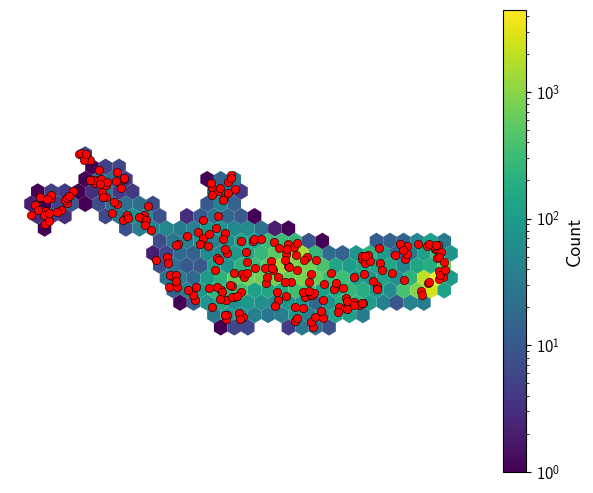

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

X = umxy[close]

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    bins="log",
    extent=get_range(X),
)

subX = X[:len(iza)]
ax.scatter(subX[:, 0], subX[:, 1], c="r", edgecolors="k", linewidths=0.4)

# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.set_aspect("equal")
ax.axis("off")

cbar = fig.colorbar(hb)
cbar.set_label("Count")

# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

## Analyzing only the structures close to selected datapoints

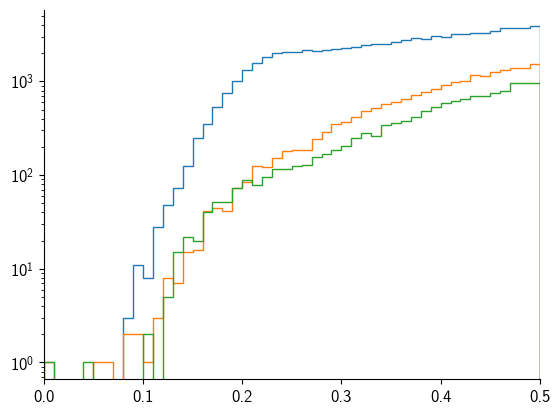

In [12]:
fig, ax = plt.subplots()

bins = np.arange(0, 0.51, 0.01)

ax.hist(hyp["BEA"], bins=bins, histtype="step")
ax.hist(hyp["CHA"], bins=bins, histtype="step")
ax.hist(hyp["FAU"], bins=bins, histtype="step")

ax.set_yscale("log")
ax.set_xlim(0, 0.5)
plt.show()

In [13]:
close = (full["BEC"] < 0.18)
print(close.sum())

632


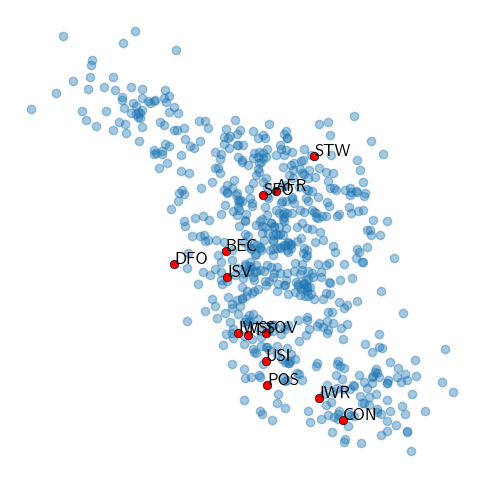

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

X = umxy[close]

# hb = ax.hexbin(
#     X[:, 0], 
#     X[:, 1],
#     gridsize=31,
#     linewidths=(0.1,),
#     mincnt=1,
#     cmap="Blues",
#     edgecolors="#808080",
#     extent=get_range(X),
# )

hb = ax.scatter(
    X[:, 0], 
    X[:, 1],
    alpha=0.4
)

subX = umxy[:len(iza)][close[:len(iza)]]
labels = iza.index[close[:len(iza)]]
ax.scatter(subX[:, 0], subX[:, 1], c="r", edgecolors="k", linewidths=0.4)

# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.set_aspect("equal")
ax.axis("off")

for _xy, label in zip(subX, labels):
    ax.annotate(label, _xy)
    
plt.show()

## Recalculating the metric instead of using it precomputed

In [15]:
um = umap.UMAP(n_neighbors=10, random_state=42, metric="cosine")
umxy = um.fit_transform(full)

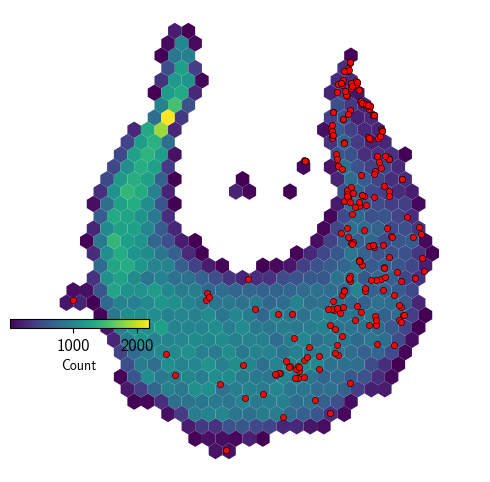

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

X = umxy

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
#     bins="log"
)

subX = X[:len(iza)]
ax.scatter(
    subX[:, 0],
    subX[:, 1],
    c="r",
    s=20,
    edgecolors="k",
    linewidths=0.4,
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.7, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

# ticks = [1e0, 1e2, 1e4]
# cbar.set_ticks(ticks)
# cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=8)
cbar.set_label("Count", fontsize=10)

# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_26809/3750362559.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)


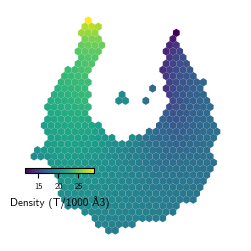

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))

X = umxy

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["density"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.6, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

# ticks = [12, 16, 20]
# cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)
cbar.set_label("Density (T/1000 Å3)", fontsize=8)

# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

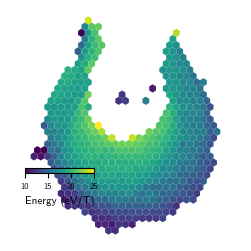

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

X = umxy

norm = plt.Normalize(10, 25)

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["relative_energy"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
    norm=norm,
)

ax.set_aspect("equal")
ax.axis("off")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.6, -0.65, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [10, 15, 20, 25]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=6)
cbar.set_label("Energy (eV/T)", fontsize=8)


# for _xy, label in zip(subX, iza.index):
#     ax.annotate(label, _xy)
    
plt.show()

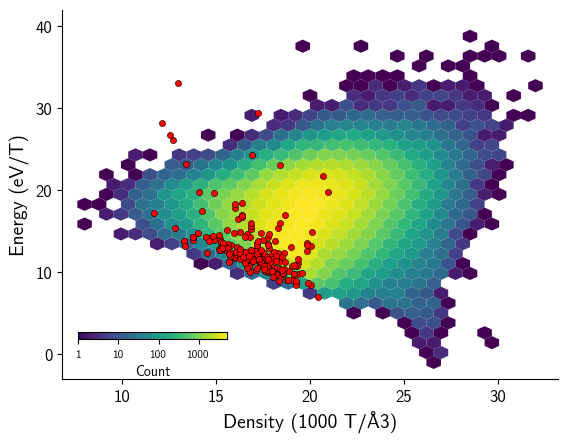

In [19]:
fig, ax = plt.subplots()

hb = ax.hexbin(
    hfeat["density"],
    hfeat["relative_energy"],
    gridsize=31,
    mincnt=1,
    linewidths=(0.,),
    bins="log",
    extent=(8, 32, -1, 40),
)

_z = zfeat.loc[zfeat["relative_energy"] < 50]

ax.scatter(
    _z["density"],
    _z["relative_energy"],
    c="r",
    s=20,
    edgecolors="k",
    linewidths=0.4,
)

ax.set_xlabel("Density (1000 T/Å3)")
ax.set_ylabel("Energy (eV/T)")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.65, -0.85, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [1e0, 1e1, 1e2, 1e3]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=8)
cbar.set_label("Count", fontsize=10)

plt.show()

## Full analysis on the 2D map of the zeolites

In [20]:
_labels = full.columns

COLS = 8
ROWS = np.ceil(len(_labels) / COLS).astype(int)
fig, ax_fig = plt.subplots(ROWS, COLS, figsize=(1 * COLS, 1 * ROWS), sharex=True)

X = umxy
xrange = get_range(X)
norm = plt.Normalize(0.2, 1.5)

for ax, label in zip(ax_fig.reshape(-1), _labels):
    hb = ax.hexbin(
        X[:, 0], 
        X[:, 1],
        C=full[label],
        gridsize=31,
        linewidths=(0.,),
        mincnt=1,
        cmap="viridis_r",
        extent=xrange,
        norm=norm,
    )
    ax.annotate(label, (0.0, 0.98), xycoords="axes fraction", ha="left", va="top", fontsize=7)


for ax in ax_fig.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect("equal")
    ax.axis("off")

fig.tight_layout()  
plt.show()